# DIPY S0s

`02-diff-dipy-S0s.ipynb` ver. 20200422

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import dipy
from dipy.io.image import save_nifti
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table

In [2]:
dipy.__version__

'1.1.1'

In [3]:
from os.path import expanduser, join
home = expanduser('~')

### Define data and result directories

In [4]:
dname = join(os.getcwd(), 'data','bids_toro')  # BIDS directory
rname = join(os.getcwd(), 'data','dipy_analysis')  # Results directory

## Preliminary exploration of first subject and first session

In [5]:
sub = 101
ses = 1

fn = 'sub-%d/ses-%d/dwi/sub-%d_ses-%d_dwi' % (sub, ses, sub, ses)
fdwi = join(dname, '%s.nii.gz' % fn)
fbval = join(dname, '%s.bval' % fn)
fbvec = join(dname, '%s.bvec' % fn)

In [6]:
data, affine, img = load_nifti(fdwi, return_img=True)

`data` is a 4D array where the first 3 dimensions are the i, j, k voxel coordinates 
and the last dimension is the number of non-weighted (S0s) and diffusion-weighted volumes.

In [7]:
print(data.shape)

(128, 128, 50, 36)


Check the dimensions of each voxel

In [8]:
print(img.header.get_zooms()[:3])

(1.7188, 1.7188, 2.4)


In [9]:
bvals, bvecs = read_bvals_bvecs(fbval, fbvec)

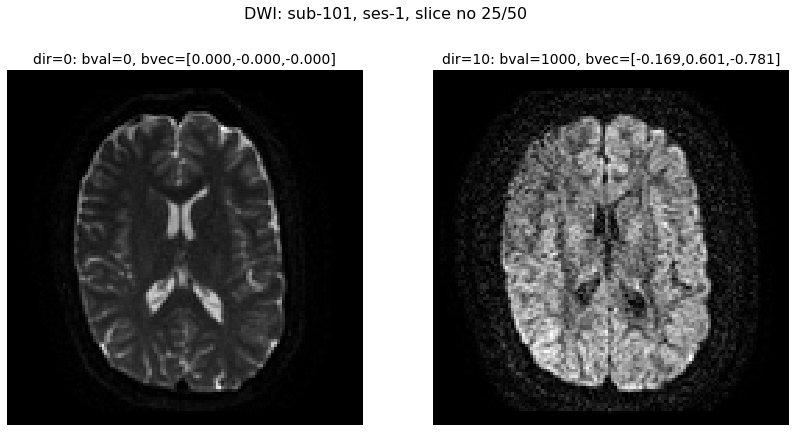

In [10]:
# Inspect data

plt.rcParams["figure.figsize"] = (14,7)

b1 = 0
b2 = 10
axial_middle = data.shape[2] // 2
plt.figure('Showing the datasets')
plt.subplot(1, 2, 1).set_axis_off()
plt.imshow(data[:, :, axial_middle, b1].T, cmap='gray', origin='lower')
plt.title('dir=%d: bval=%.0f, bvec=[%.3f,%.3f,%.3f]' % (b1, bvals[b1], bvecs[b1][0],bvecs[b1][1], bvecs[b1][2]), size=14)
plt.subplot(1, 2, 2).set_axis_off()
plt.imshow(data[:, :, axial_middle, b2].T, cmap='gray', origin='lower')
plt.title('dir=%d: bval=%.0f, bvec=[%.3f,%.3f,%.3f]' % (b2, bvals[b2], bvecs[b2][0],bvecs[b2][1], bvecs[b2][2]), size=14)
plt.suptitle('DWI: sub-%d, ses-%d, slice no %d/%d' % (sub, ses, axial_middle, data.shape[2]), size=16)
plt.savefig('./assets/dipy_data.png', bbox_inches='tight')
plt.show()

In DIPY, we use an object called `GradientTable` which holds all the acquisition specific parameters, e.g. b-values, b-vectors, timings and others. 

In [11]:
gtab = gradient_table(bvals, bvecs)

In [12]:
print(gtab.bvals)

[   0.    0.    0.    0.    0.    0. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.
 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]


In [13]:
print(gtab.bvecs[:11, :])

[[ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 0.     0.     0.   ]
 [ 1.    -0.    -0.   ]
 [ 0.166 -0.986 -0.   ]
 [-0.11  -0.664 -0.74 ]
 [ 0.901  0.419  0.11 ]
 [-0.169  0.601 -0.781]]


`gtab` can be used to tell what part of the data is the S0 volumes (volumes which correspond to b-values of 0)

In [14]:
S0s = data[:, :, :, gtab.b0s_mask]

In [15]:
print(S0s.shape)
print(S0s.shape[-1])

(128, 128, 50, 6)
6


We save this in a new Nifti file

In [16]:
fnS0s = join(rname, 'sub_%d_tp%d_dwi_S0.nii.gz' % (sub, ses))
save_nifti(fnS0s, S0s, affine)

## Define function `extract_S0s`

In [17]:
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.io.image import save_nifti

def extract_S0s(inpdir, sub, ses, outdir):
    """
    Extract S0s from dwi file
    Usage:
    Ex: 
    """
    
    fn = 'sub-%d/ses-%d/dwi/sub-%d_ses-%d_dwi' % (sub, ses, sub, ses)
    fdwi = join(inpdir, '%s.nii.gz' % fn)
    #print(fdwi)
    fbval = join(inpdir, '%s.bval' % fn)
    fbvec = join(inpdir, '%s.bvec' % fn)
    
    bvals, bvecs = read_bvals_bvecs(fbval, fbvec)
    gtab = gradient_table(bvals, bvecs)
    data, affine, img = load_nifti(fdwi, return_img=True)
    S0s = data[:, :, :, gtab.b0s_mask]
    nS0s = S0s.shape[-1]
    
    fnS0s = join(outdir, 'sub_%d_tp%d_dwi_S0.nii.gz' % (sub, ses))
    save_nifti(fnS0s, S0s, affine)
    
    return S0s, affine, nS0s

In [18]:
# Testing function for single subject, single examination
from os.path import expanduser, join
home = expanduser('~')
inpdir = join(home, 'prj','BrainGut','GE_Signa3T','bids_toro')
sub = 101
ses = 1
outdir = join(home, 'prj','BrainGut','GE_Signa3T','dipy_analysis')

S0s, affine, nS0s = extract_S0s(inpdir, sub, ses, outdir)
print('affine:\n', affine)
print('nS0s:', nS0s)

affine:
 [[-1.71878457e+00  2.46537803e-03  9.42857098e-03  1.11098900e+02]
 [ 1.15396967e-03  1.68905962e+00 -4.44530606e-01 -7.25265732e+01]
 [ 7.08135264e-03  3.18350971e-01  2.35845304e+00 -6.13285751e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
nS0s: 6


In [19]:
S0s_mean = S0s.mean(axis=-1)
nS0s = S0s.shape[-1]
print('S0s.shape:', S0s.shape)
print('S0s_mean.shape:', S0s_mean.shape)
print('nS0s:', nS0s)

fnS0s_mean = join(outdir, 'sub_%d_tp%d_dwi_S0_mean_of_%d.nii.gz' % (sub, ses, nS0s))
save_nifti(fnS0s_mean, S0s_mean, affine)

S0s.shape: (128, 128, 50, 6)
S0s_mean.shape: (128, 128, 50)
nS0s: 6


In [20]:
# !fsleyes ~/prj/BrainGut/GE_Signa3T/dipy_analysis/sub_101_tp1_dwi_S0.nii.gz

## Run for all subjects

In [21]:
from os.path import expanduser, join
import sys
sys.path.append('.')   # path to utils.py
import utils
import time

inpdir = dname
ses = 1
outdir = rname

In [22]:
%%time
nsubj = 1 # 30
ses=1
for i in utils.progressbar(range(nsubj), "Computing: ", 40):
    time.sleep(0.1)
    sub = i+101
    S0s, affine, nS0s = extract_S0s(inpdir, sub, ses, outdir)
    
    S0s_mean = S0s.mean(axis=-1)
    nS0s = S0s.shape[-1]
    fnS0s_mean = join(outdir, 'sub_%d_tp%d_dwi_S0_mean.nii.gz' % (sub, ses))
    save_nifti(fnS0s_mean, S0s_mean, affine)

Computing: [########################################] 1/1
CPU times: user 6.1 s, sys: 127 ms, total: 6.23 s
Wall time: 698 ms
